In [2]:
# Libraries
import os
import sys
import numpy as np
import pandas as pd
import scipy.special as sspec
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from matplotlib import colors as mcolors

# Plot parameters
plt.rcParams.update({
    'lines.linewidth': 2,          # linewidth
    'text.usetex': True,           # LaTeX font
    'font.family': 'sans serif',   # Serif family
    'font.size': 20,               # font size
    'axes.titlesize': 24,          # title size
    'axes.grid': True,             # grid
    'grid.linestyle': "-.",        # grid style
})

I used the next block of code to change the encoding of the original files from the experiment. The output is shown in the folder ./tmp/coherence_measurements.

In [17]:
# idx = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70]

# # Open the files, change the coding, and store them in a separate folder
# for i in range(len(idx)):
#     fh = open(f'./archivos/coherence_{idx[i]}.csv', 'r', encoding = 'iso-8859-1')
#     tfh = open(f'./tmp/coherence_measurements/coherence_{idx[i]}.csv','w')

#     for line in fh:
#         line1 = line.replace(',','.').replace(';',',')
#         tfh.write(line1)

#     fh.close()
#     tfh.close()

'\nHere, I opened all the files with the coherence measurments and decoded the files. I still changed \nthe headers of each column so I could read them easily. \n'

For the data analysis, I required to make several sine function fits. To do so, I used the fit model
$$ 
f(x) = A \sin(b x + c) + d,
$$

where $A$ is the amplitude, $b$ is the period, $c$ is the phase, and $d$ is the offset. I started openning the files and defining the fit model in the script.

In [3]:
# Last 
idx = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70]

# Files
path_files = './tmp/coherence_measurements'
data = [pd.read_csv(os.path.join(path_files, f'coherence_{i}.csv')).reset_index() for i in idx]

# Curve to fit
def test_sin(x, amplitude, period, phase, offset):
    return amplitude * np.sin(period * x + phase) + offset

Here, I used a 'for' loop to obtain the experimental visibility using the fit parameters for each measurement. The visibility is defined as the difference between the maxima and the minima over their addition, 
$$
\mathcal{V} = \dfrac{C_{\mathrm{max}} - C_{\mathrm{min}}}{C_{\mathrm{max}} + C_{\mathrm{min}}},
$$

and the error propagation was accounted as
$$
\sigma_{\mathcal{V}} = \mathcal{V} \sqrt{\dfrac{\sigma_{A}^2}{A_{\mathrm{fit}}^2} + \dfrac{\sigma_{d}^2}{d_{\mathrm{fit}}^2}},
$$

where $A_{\mathrm{fit}}$ is the amplitude from the fit, $\sigma_{A}$ is its standard deviation, $d_{\mathrm{fit}}$ is the offset from the fit, and $\sigma_{d}$ is its standard deviation. Here I showed an example of an interferogram with its sine fit:

In [ ]:
# Data
data_c0 = pd.read_csv('./tmp/coherence_measurements/coherence_10.csv')

# Variables
stage_position_c0 = data_c0['stage_position'].values          # Stage position (um)
coincidence_rate_c0 = data_c0['coincidence_rate_t_b'].values  # Coincidence rate T & B

# Initial guesses (test amplitude, test period, test phase, test offset)
initial_guess_c0 = [(np.max(coincidence_rate_c0) - np.min(coincidence_rate_c0)) / 2,
                    2 * np.pi / 0.404,
                    0,
                    np.mean(coincidence_rate_c0)]

# === Curve fitting ===
params_c0, covariance_c0 = curve_fit(test_sin, stage_position_c0, coincidence_rate_c0 , p0 = initial_guess_c0)

# Curve fitted
position_fit_c0 = np.linspace(min(stage_position_c0), max(stage_position_c0), 500)
sin_fit_c0 = test_sin(position_fit_c0, *params_c0)

Plot of the interferogram with its sine fit:

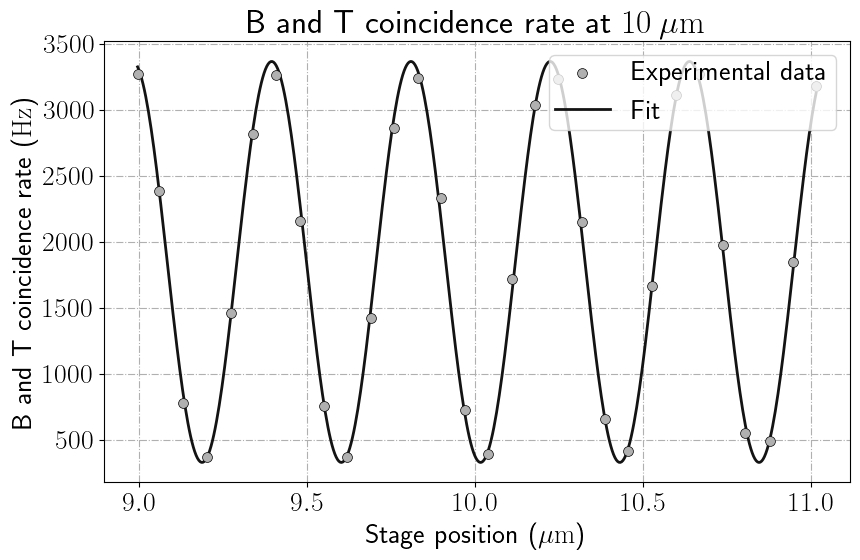

In [ ]:
# Figure size
plt.figure(figsize = (9, 6))

# Figure title and legends
plt.title(r'\textsf{B and T coincidence rate at $10 \: \mathrm{\mu \mathrm{m}}$}')
plt.xlabel(r'\textsf{Stage position ($\mu \mathrm{m}$)}')
plt.ylabel(r'\textsf{B and T coincidence rate ($\mathrm{Hz}$)}')

# Plot of the stage position against the fit of the coincidence rate
plt.scatter(stage_position_c0, coincidence_rate_c0, facecolor = '#B0B0B0', 
            edgecolor = '#000000', linewidth = 0.5, s = 50, zorder = 4, label = r'\textsf{Experimental data}')
plt.plot(position_fit_c0, sin_fit_c0, label = r'\textsf{Fit}', color = '#131313')

# Final figure parameters
plt.legend(loc = 'upper right', borderpad = 0.2)
plt.tight_layout()
plt.savefig('./figures/int_coherence.pdf')

In [ ]:
# Initialized the empty list where I stored the visibilities
visibilities = []
exp_visibilities = []
sd_visibilities = []

for cdata in data:
    # Variables
    stage_position = cdata['stage_position'].values
    coincidence_bt = cdata['coincidence_rate_t_b'].values

    # Experimental visibility
    exp_visibility = [(np.max(coincidence_bt) - np.min(coincidence_bt)) / (np.max(coincidence_bt) + np.min(coincidence_bt))]

    # Initial guesses (test amplitude, test period, test phase, test offset)
    initial_guess = [(np.max(coincidence_bt) - np.min(coincidence_bt)) / 2,
                    2 * np.pi / 0.404,
                    0,
                    np.mean(coincidence_bt)]

    # === Curve fitting ===
    params, pcov = curve_fit(test_sin, stage_position, coincidence_bt , p0 = initial_guess)

    # Fit
    position_fit = np.linspace(min(stage_position), max(stage_position), 500)
    sin_fit = test_sin(position_fit, *params)

    # Statistical parameters of the fit
    perr = np.sqrt(np.diag(pcov))
    sd_amplitude, sd_period, sd_phase, sd_offset = perr

    # Visibility
    minmax = [np.min(sin_fit), np.max(sin_fit)]
    visibility = np.diff(minmax) / sum(minmax)

    # Sd. deviation of the visibility
    sd_visibility = visibility * np.sqrt(
            sd_amplitude ** 2 / params[0] ** 2 + sd_offset ** 2 / params[3] ** 2)

    # Appending the results
    visibilities.append(visibility[0])
    exp_visibilities.append(exp_visibility[0])
    sd_visibilities.append(sd_visibility[0])

# Best visibility
max_visibility = np.max(visibilities)
max_visibility_index = np.argmax(visibilities)

# Print the value of the best visibility
print(f"Best visibility = {max_visibility:.2f} ± {sd_visibilities[max_visibility_index]:.2f}")

Best visibility = 0.82 ± 0.01


The next part was to plot the visibility against the position of the stage. 

In [13]:
# Position of the fine adjuster
fine_adjuster_position = np.array([-52, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])

# Storing the data in a separate file
df = pd.DataFrame({"fine_adjuster_position" : fine_adjuster_position, "visibilities" : visibilities, 
                   "sd_error_visibility" : sd_visibilities, "experimental_visibilities" : exp_visibilities})
df.to_csv("visibility.csv", index = False)

data_v = pd.read_csv('./visibility.csv')

# Data variables
visibility_fit = data_v['visibilities'].values               # Fitted visibilities
visibility_exp = data_v['experimental_visibilities'].values  # Measured visibilities
errors_visibilities = data_v['sd_error_visibility'].values   # Error in the fitted visibility

The functional form of the visibility was
$$
\mathcal{V}(x) = A \left| \mathrm{sinc}(b x + c) \right| + d,
$$

where $A$ is the amplitude, $b$ is the period, $c$ is the phase, and $d$ is the offset (similar as in the sine fit).

In [14]:
# Visibility functional form fit
def sincabs(x, a, b, c, d):
    argument = np.pi * (b * x + c)
    result = np.where(argument == 0, a + d, 
                      a * np.abs(np.sin(argument / np.pi) / (argument / np.pi))) + d
    return result

# Initial guesses
in_guess = [np.max(visibilities), 0.01, 0.00, np.min(visibilities)]

# === Curve fitting ===
params_sinc, pcov_sinc = curve_fit(sincabs, fine_adjuster_position, visibilities, p0 = in_guess)

# Fitted curve
posicion_fit_sinc = np.linspace(min(fine_adjuster_position), max(fine_adjuster_position), 500)
visibilidad = sincabs(posicion_fit_sinc, *params_sinc)

/tmp/ipykernel_651/3933111323.py:5: RuntimeWarning: invalid value encountered in divide
  a * np.abs(np.sin(argument / np.pi) / (argument / np.pi))) + d


Once I computed the fit visibility, I plotted the results in the following section.

Amplitude: 0.79 ± 0.04
Period: 0.05 ± 0.0016
Phase: 0.31 ± 0.05
Offset: 0.03 ± 0.03


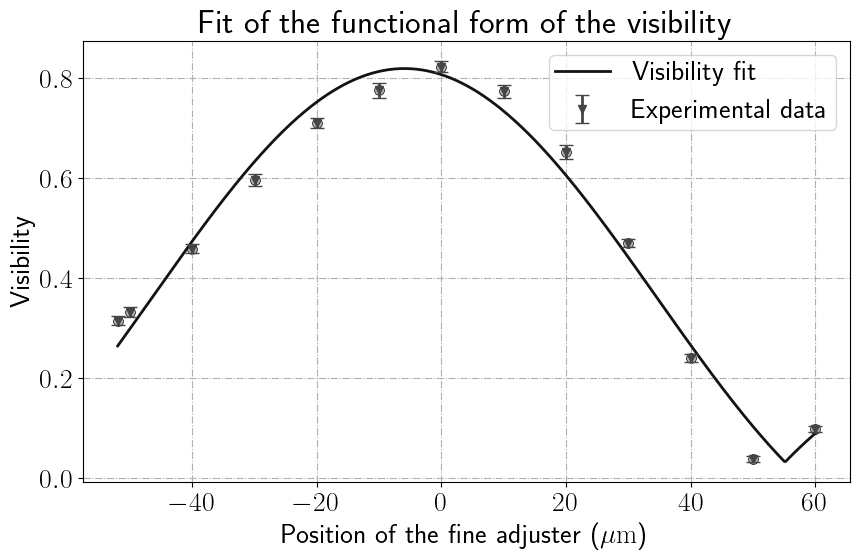

In [15]:
# Figure size
plt.figure(figsize = (9, 6))

# Figure title and legends
plt.title(r"\textsf{Fit of the functional form of the visibility}")
plt.xlabel(r"\textsf{Position of the fine adjuster ($\mu \mathrm{m}$)}")
plt.ylabel(r"\textsf{Visibility}")

# Plot of the fine adjuster position against the visibility fitted and experimental visibility
plt.scatter(fine_adjuster_position, visibility_fit, facecolor = '#B0B0B0',
            edgecolor = '#000000', linewidth = 0.5, s = 50)
plt.plot(posicion_fit_sinc, visibilidad, color = '#131313', label = r'\textsf{Visibility fit}')

# Plot of the errors
plt.errorbar(fine_adjuster_position, visibility_fit, yerr = errors_visibilities, 
             fmt = 'v', capsize = 5, color = '#464543', label = r'\textsf{Experimental data}')

# Final figure parameters
plt.legend(loc = 'upper right', borderpad = 0.2)
plt.tight_layout()
plt.savefig('./figures/visibility_fit.pdf')

# Standard deviation
perr_sinc = np.sqrt(np.diag(pcov_sinc))
sd_amplitude_sinc, sd_period_sinc, sd_phase_sinc, sd_offset_sinc = perr_sinc

# Standard deviation of the visibility fitted
sd_visibility_fitted = visibilidad * np.sqrt(
            sd_amplitude_sinc**2 / params_sinc[0] ** 2 + sd_offset_sinc**2 / params_sinc[3]**2)

# Parameters of the fit
print(f'Amplitude: {params_sinc[0]:.2f} ± {sd_amplitude_sinc:.2f}')
print(f'Period: {params_sinc[1]:.2f} ± {sd_period_sinc:.4f}')
print(f'Phase: {params_sinc[2]:.2f} ± {sd_phase_sinc:.2f}')
print(f'Offset: {params_sinc[3]:.2f} ± {sd_offset_sinc:.2f}')

The next step was to determine the coherence length. To do so, we started from the maximum visibility and identified the maximum value of the visibility and divided by $e$. I subtracted this value from the function and took the absolute value of the result. Then, I inspected the position of the values where the result was close to the threshold and, once we identified the position of the two indices, we calculated their distance.

In [16]:
# Find the maximum value and threshold
visibility_max = np.max(visibilidad)
y_threshold = visibility_max / np.e

# Find the indices of the points closest to the threshold on both sides
abs_diff = np.abs(visibilidad - y_threshold)

# Indices of the closest points
idx_left = np.argmin(abs_diff[posicion_fit_sinc < 0])  # On the left side of the peak
idx_right = np.argmin(abs_diff[posicion_fit_sinc > 0]) + np.argmax(posicion_fit_sinc > 0)  # On the right side

# Corresponding x values
x_left = posicion_fit_sinc[idx_left]
x_right = posicion_fit_sinc[idx_right]

# Coherence length is half the width between the points
coherence_length = (x_right - x_left) / 2

print(f'Coherence length: {coherence_length:.2f}')

Coherence length: 43.99
